In [1]:
# pyqubo stuff
from pyqubo import Array, Constraint
from mpl_toolkits.mplot3d import Axes3D

import math
import matplotlib.pyplot as plt
import numpy as np
import re
import neal
import itertools

In [85]:
SQUARE_SIZE = 4
BITS = math.floor(math.log2(SQUARE_SIZE**2) + 1)
VARS = SQUARE_SIZE * SQUARE_SIZE * BITS
VARS

80

In [86]:
# get the vector index given the i, j, k magic square matrix identifiers
def get_index(i, j, k):
    
    # we need to know the length of the magic square matrix horizontally
    row_length = BITS * SQUARE_SIZE
    
    return int((i*row_length) + (j*BITS) + k)

## QUBO Implementation

$$S_{\text{row=i}} = \sum_{j=1}^{n}\sum_{k=1}^{s}x_{i,j,k} * 2^{s-k}$$
$$P_{\text{row}} = \sum_{i1>i2}^{n}\left[\sum_{j=1}^{n}\sum_{k=1}^{s}x_{i2,j,k} * 2^{s-k} - \sum_{j=1}^{n}\sum_{k=1}^{s}x_{i1,j,k} * 2^{s-k}\right]^2$$

In [87]:
def implement_row(H, variables, penalty=1):
    for row1 in range(SQUARE_SIZE):
        for row2 in range(row1, SQUARE_SIZE):
            if row1 == row2:
                continue

            H_row1 = 0
            H_row2 = 0

            for j in range(SQUARE_SIZE):
                H_row1 += Constraint(penalty * np.sum([list(variables)[get_index(row1,j,k)] * np.pow(2, BITS-k-1) for k in range(BITS)]), label=f"row_{row1}_{j}")

            for j in range(SQUARE_SIZE):
                H_row2 += Constraint(penalty * np.sum([list(variables)[get_index(row2,j,k)] * np.pow(2, BITS-k-1) for k in range(BITS)]), label=f"row_{row2}_{j}")


            H += (H_row1 - H_row2) ** 2
        
    return H
            

$$S_{\text{col=j}} = \sum_{i=1}^{n}\sum_{k=1}^{s}x_{i,j,k} * 2^{s-k}$$
$$P_{\text{col}} = \sum_{j1>j2}^{n}\left[\sum_{i=1}^{n}\sum_{k=1}^{s}x_{i,j2,k} * 2^{s-k} - \sum_{i=1}^{n}\sum_{k=1}^{s}x_{i,j1,k} * 2^{s-k}\right]^2$$

In [88]:
def implement_col(H, variables, penalty=1):
    for col1 in range(SQUARE_SIZE):
        for col2 in range(col1, SQUARE_SIZE):
            if col1 == col2:
                continue

            H_col1 = 0
            H_col2 = 0

            for i in range(SQUARE_SIZE):
                H_col1 += Constraint(penalty * np.sum([list(variables)[get_index(i,col1,k)] * np.pow(2, BITS-k-1) for k in range(BITS)]), label=f"row_{i}_{col1}")

            for i in range(SQUARE_SIZE):
                H_col2 += Constraint(penalty * np.sum([list(variables)[get_index(i,col2,k)] * np.pow(2, BITS-k-1) for k in range(BITS)]), label=f"row_{i}_{col2}")


            H += (H_col1 - H_col2) ** 2
        
    return H
            

$$S_{\text{row=i}} = \sum_{j=1}^{n}\sum_{k=1}^{s}x_{i,j,k} * 2^{s-k}$$
$$S_{\text{col=j}} = \sum_{i=1}^{n}\sum_{k=1}^{s}x_{i,j,k} * 2^{s-k}$$

$$S_{\text{rowcol}} = \sum_{i<j}^{n}\left[\sum_{j=1}^{n}\sum_{k=1}^{s}x_{i,j,k} * 2^{s-k} - \sum_{i=1}^{n}\sum_{k=1}^{s}x_{i,j,k} * 2^{s-k}\right]^2$$

In [89]:
def implement_row_col(H, variables, penalty=1):
    for row1 in range(SQUARE_SIZE):
        for col1 in range(SQUARE_SIZE):
            H_tmp = 0
            
            for j in range(SQUARE_SIZE):
                H_tmp += np.sum([list(variables)[get_index(row1,j,k)] * np.pow(2, BITS-k-1) for k in range(BITS)])

            for i in range(SQUARE_SIZE):
                H_tmp -= np.sum([list(variables)[get_index(i,col1,k)] * np.pow(2, BITS-k-1) for k in range(BITS)])

            H_tmp **= 2
            
            H += Constraint(H_tmp, label=f"row_{row1}_{col1}")

    return penalty * H
            

$$\sum_{i1,j1>i2,j2}^{n}\left[\sum_{k=1}^{s}1 - (2x_{i1,j1,k}x_{i2,j2,k} - x_{i1,j1,k} - x_{i2,j2,k})\right]$$

In [90]:
def implement_unique_2(H, variables, penalty=1):
    
    for i1 in range(SQUARE_SIZE):
        for j1 in range(SQUARE_SIZE):
            for i2 in range(i1, SQUARE_SIZE):
                for j2 in range(SQUARE_SIZE):
                    if i1 == i2 and j2 <= j1:
                        continue

                    H_tmp = 0

                    for k in range(BITS):
                        var1 = variables[get_index(i1,j1,k)]
                        var2 = variables[get_index(i2,j2,k)]
                        
                        # H_tmp += (var1 * var2 - var1 - var2)
                        H_tmp += 1 - ((var1 + var2) - (2 * var1 * var2))

                    H +=  Constraint(H_tmp, label=f"unique_{i1}_{j1}_{i2}_{j2}")
                    
    return penalty * H

$$\sum_{}$$

In [91]:
def implement_range(H, variables, penalty=1):
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
            H_tmp = 0

            for k in range(BITS):
                var = variables[get_index(i,j,k)]
                
                H_tmp += (2 ** (BITS-k-1)) * var

            H_tmp -= 8
            H_tmp **= 2

            H += Constraint(H_tmp, label=f"inrange_{i}_{j}")

    return penalty * H

In [92]:
def implement_range2(H, variables, penalty=1):
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
            var1 = variables[get_index(i,j,0)]
            var2 = variables[get_index(i,j,1)]
            var3 = variables[get_index(i,j,2)]
            var4 = variables[get_index(i,j,3)]

            H += (var4 * var1 + var4 * var2 + var4 * var3)
            

    return penalty * H

            

In [93]:
def implement_range3(H, variables, penalty=1):
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
            var1 = variables[get_index(i,j,0)]
            var2 = variables[get_index(i,j,1)]
            var3 = variables[get_index(i,j,2)]
            var4 = variables[get_index(i,j,3)]

            H += 1 - ((1-var1) * (1-var2) * (1-var3) * var4)
            

    return penalty * H

In [94]:
def implement_range4(H, variables, penalty=1):

    # generate all combinations of binaries which should be penalised individually
    forbidden_binary_combinations = [format(i, f"0{BITS}b") for i in range(SQUARE_SIZE ** 2, 2 ** BITS)]

    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
            H_tmp = 0
            
            for forbidden_binary in forbidden_binary_combinations:
                # iterate over all quadratic combinations of 
                for forbidden_combo, variable_combo in zip(itertools.combinations(forbidden_binary, 2), itertools.combinations([variables[get_index(i,j,k)] for k in range(BITS)], 2)):
                    H_tmp += ((int(forbidden_combo[0]) * variable_combo[0]) * (int(forbidden_combo[1]) * variable_combo[1]))

            H_tmp **= 2
                    
              

            # H_tmp **= 2
            H += Constraint(H_tmp, label=f"range_{i}_{j}")

    return penalty * H

## Construct QUBO

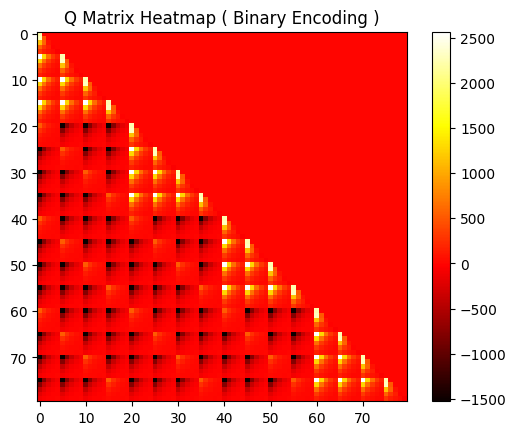

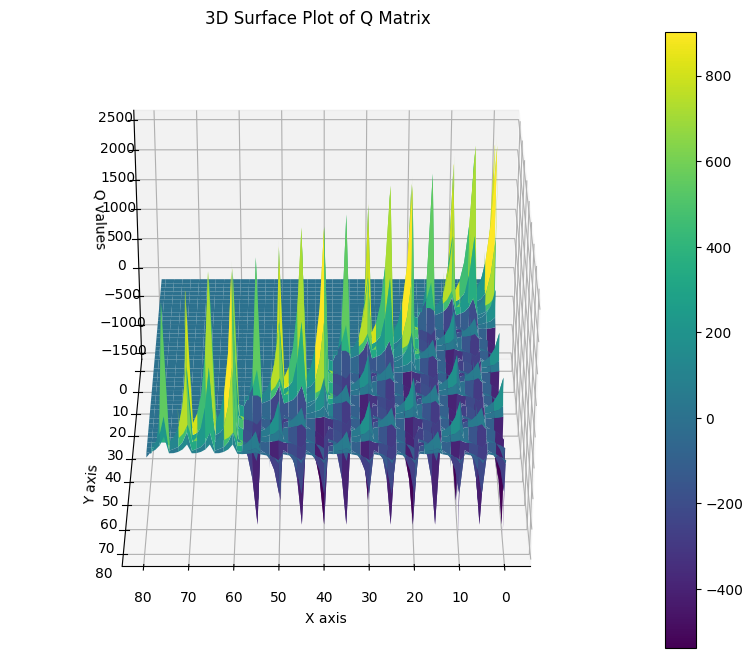

In [95]:
def show_2d(H):
    model = H.compile()
    qubo, offset = model.to_qubo()

    Q = np.zeros((SQUARE_SIZE * SQUARE_SIZE * BITS, SQUARE_SIZE * SQUARE_SIZE * BITS))

    for key, value in qubo.items():
        i = int(re.search(r'\[(\d+)\]', key[0]).group(1))
        j = int(re.search(r'\[(\d+)\]', key[1]).group(1))

        if i > j:
            Q[i][j] = value
        elif i <= j:
            Q[j][i] = value


    plt.title("Q Matrix Heatmap ( Binary Encoding )")
    plt.imshow(Q, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()

def show_3d(H):

    model = H.compile()
    qubo, offset = model.to_qubo()

    Q = np.zeros((SQUARE_SIZE * SQUARE_SIZE * BITS, SQUARE_SIZE * SQUARE_SIZE * BITS))

    for key, value in qubo.items():
        i = int(re.search(r'\[(\d+)\]', key[0]).group(1))
        j = int(re.search(r'\[(\d+)\]', key[1]).group(1))

        if i > j:
            Q[i][j] = value
        elif i <= j:
            Q[j][i] = value
    
    # Create a meshgrid for the indices of the Q matrix
    x = np.arange(Q.shape[0])
    y = np.arange(Q.shape[1])
    x, y = np.meshgrid(x, y)

    # Create a figure and a 3D axis
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surf = ax.plot_surface(x, y, Q, cmap='viridis')

    # Add a color bar which maps values to colors
    fig.colorbar(surf)
        
    # Set labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Q values')

    # Set title
    ax.set_title('3D Surface Plot of Q Matrix')

    ax.view_init(elev=30, azim=90)  # Adjust 'elev' as needed for better visibility

    plt.show()

array = Array.create('x', VARS, 'BINARY')

# apply constraints
H = 0

# H += implement_unique(H, array, 1)
# H += implement_row_col(H, array, 1)

H += implement_unique_2(H, array, 1)
H += implement_row(H, array, 1)
H += implement_col(H, array, 1)

# H += implement_range(H, array, 1)
# H += implement_range2(H, array, 1)
# H += implement_range3(H, array, 1)
# H += implement_range4(H, array, 5)


show_2d(H)
show_3d(H)




## Get Optimal Energy

In [96]:
array

Array([Binary('x[0]'), Binary('x[1]'), Binary('x[2]'), Binary('x[3]'), Binary('x[4]'), Binary('x[5]'), Binary('x[6]'), Binary('x[7]'), Binary('x[8]'), Binary('x[9]'), Binary('x[10]'), Binary('x[11]'), Binary('x[12]'), Binary('x[13]'), Binary('x[14]'), Binary('x[15]'), Binary('x[16]'), Binary('x[17]'), Binary('x[18]'), Binary('x[19]'), Binary('x[20]'), Binary('x[21]'), Binary('x[22]'), Binary('x[23]'), Binary('x[24]'), Binary('x[25]'), Binary('x[26]'), Binary('x[27]'), Binary('x[28]'), Binary('x[29]'), Binary('x[30]'), Binary('x[31]'), Binary('x[32]'), Binary('x[33]'), Binary('x[34]'), Binary('x[35]'), Binary('x[36]'), Binary('x[37]'), Binary('x[38]'), Binary('x[39]'), Binary('x[40]'), Binary('x[41]'), Binary('x[42]'), Binary('x[43]'), Binary('x[44]'), Binary('x[45]'), Binary('x[46]'), Binary('x[47]'), Binary('x[48]'), Binary('x[49]'), Binary('x[50]'), Binary('x[51]'), Binary('x[52]'), Binary('x[53]'), Binary('x[54]'), Binary('x[55]'), Binary('x[56]'), Binary('x[57]'), Binary('x[58]'), 

In [99]:
def create_magic_square(n):
    """Create an n x n magic square."""
    if n % 2 == 1:
        # Odd order: Siamese method
        magic = np.zeros((n, n), dtype=int)
        i, j = 0, n // 2

        for num in range(1, n * n + 1):
            magic[i, j] = num
            i_new, j_new = (i-1) % n, (j+1) % n
            if magic[i_new, j_new]:
                i += 1
            else:
                i, j = i_new, j_new
    else:
        raise NotImplementedError("Only odd order magic squares are implemented here.")
    return magic

def magic_square_to_binary_array(magic):
    """Convert a magic square to a flattened array of binary digits."""
    n = magic.shape[0]
    max_num = int(magic.max())
    bits_needed = (max_num - 1).bit_length()
    print(bits_needed)

    binary_array = []
    for num in magic.flatten():
        bits = [int(b) for b in format(num, f'0{bits_needed}b')]
        binary_array.extend(bits)
    
    return binary_array

# Example usage:
  # Order of the magic square
# magic = create_magic_square(SQUARE_SIZE)

# magic = np.array([[ 5,  3, 12], [ 1, 11,  8], [14,  6,  0]]) # semi magic square
# magic = np.array([[8,1,6], [3,5,7], [4,9,2]]) # magic square

magic = np.array([[ 9,  8, 28, 13], [26, 22, 10,  0], [ 3, 21, 19, 15], [20,  7,  1, 30,]]) # semi magic square
# magic = np,array([[16,  2,  3, 13], [ 5, 11, 10,  8], [ 9,  7,  6, 12], [ 4, 14, 15,  1]]) # magic square

# magic = np,array([[15,  8, 11, 31, 11], [21, 20, 19,  2, 14], [28,  8, 24,  5, 11], [12, 18, 21,  8, 17], [ 0, 22,  1, 30, 23]]) # semi magic square
# magic = np,array([[17, 24,  1,  8, 15], [23,  5,  7, 14, 16], [ 4,  6, 13, 20, 22], [10, 12, 19, 21,  3], [11, 18, 25,  2,  9]]) # magic square

binary_array = magic_square_to_binary_array(magic)
print(len(binary_array))

5
80


In [100]:
a = {} 
vars = [str(i)[8:-2] for i in array]
print(vars)


for i in range(0, len([str(i)[8:-2] for i in array])):
    a.setdefault(vars[i], binary_array[i])

model = H.compile()
decoded = model.decode_sample(a, vartype='BINARY')
decoded.energy

['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]', 'x[7]', 'x[8]', 'x[9]', 'x[10]', 'x[11]', 'x[12]', 'x[13]', 'x[14]', 'x[15]', 'x[16]', 'x[17]', 'x[18]', 'x[19]', 'x[20]', 'x[21]', 'x[22]', 'x[23]', 'x[24]', 'x[25]', 'x[26]', 'x[27]', 'x[28]', 'x[29]', 'x[30]', 'x[31]', 'x[32]', 'x[33]', 'x[34]', 'x[35]', 'x[36]', 'x[37]', 'x[38]', 'x[39]', 'x[40]', 'x[41]', 'x[42]', 'x[43]', 'x[44]', 'x[45]', 'x[46]', 'x[47]', 'x[48]', 'x[49]', 'x[50]', 'x[51]', 'x[52]', 'x[53]', 'x[54]', 'x[55]', 'x[56]', 'x[57]', 'x[58]', 'x[59]', 'x[60]', 'x[61]', 'x[62]', 'x[63]', 'x[64]', 'x[65]', 'x[66]', 'x[67]', 'x[68]', 'x[69]', 'x[70]', 'x[71]', 'x[72]', 'x[73]', 'x[74]', 'x[75]', 'x[76]', 'x[77]', 'x[78]', 'x[79]']


1124.0

## Perform Simulated Annealing

In [97]:
# compile and convert to binary quadratic model
model = H.compile()
bqm = model.to_bqm()

# simulate
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=1000)
decoded_samples = model.decode_sampleset(sampleset)

# decode
solutions = []

for solution in decoded_samples:
    
    # get the sample and energy
    sample = solution.sample
    energy = solution.energy
    
    sample = np.array([sample[f"x[{i}]"] for i in range(SQUARE_SIZE * SQUARE_SIZE * BITS)]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))  

    solutions.append({"sample": sample, "energy": energy})

## Perform Real Annealing

## Analyse

In [98]:
def get_grid(sample):
    grid = np.zeros((SQUARE_SIZE, SQUARE_SIZE))
    
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):

            # get the item
            item = list(sample[i][j])
            index = int("".join([str(int(i)) for i in item]), 2)
            grid[i][j] = index
            
    return np.array(grid)

def check_binary(sample):

    # count how many samples are not binary encoded
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
            if sum(sample[i][j]) == 0:
                return False
            
    # return True if all samples are one hot encoded
    return True

def check_range(sample):
    # get grid
    grid = get_grid(sample)

    # test for range
    if all(grid.flatten() < SQUARE_SIZE**2):
        return True
    
    return False

def check_unique(sample):
    
    # get grid
    grid = get_grid(sample)

    # test for uniqueness
    if len(set(grid.flatten())) == SQUARE_SIZE**2:
        return True
    
    return False

def check_sum_col(sample):

    # get grid and sum cols
    grid = get_grid(sample)
    sums = [int(sum(grid[:,i])) for i in range(SQUARE_SIZE)]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

def check_sum_row(sample):
    
    # get grid and sum rows
    grid = get_grid(sample)
    sums = [int(sum(grid[i,:])) for i in range(SQUARE_SIZE)]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

def check_magic(sample):
    if check_sum_col(sample) and check_sum_row(sample) and check_unique(sample):
        return True
    return False


binary = 0
unique = 0
sumcol = 0
sumrow = 0
inrange = 0
magic = 0


for solution in solutions:
    # if check_binary(solution["sample"]) is True:
    #     binary += 1
    # else:   
    #     continue # avoid checking for unique if the ohe is not correct

    # print(get_grid(solution["sample"]))
    
    if check_unique(solution["sample"]):
        unique += 1
        # print(f"Unique: {get_grid(solution['sample'])}")

    if check_sum_col(solution["sample"]):
        sumcol += 1

    if check_sum_row(solution["sample"]):
        sumrow += 1

    if check_range(solution["sample"]):
        inrange += 1

    if check_magic(solution["sample"]):
        print(get_grid(solution["sample"]))
        magic += 1


# print(f"Binary Correct: {binary}/{len(solutions)}")
print(f"Unique Correct: {unique}/{len(solutions)}")
print(f"Sum Column Correct: {sumcol}/{len(solutions)}")
print(f"Sum Row Correct: {sumrow}/{len(solutions)}")
print(f"Range Correct: {inrange}/{len(solutions)}")
print(f"Magic Correct: {magic}/{len(solutions)}")

[[ 9.  8. 28. 13.]
 [26. 22. 10.  0.]
 [ 3. 21. 19. 15.]
 [20.  7.  1. 30.]]
[[16. 29.  4.  9.]
 [ 6.  7. 27. 18.]
 [25. 10. 22.  1.]
 [11. 12.  5. 30.]]
[[21. 23. 16.  6.]
 [10. 15. 24. 17.]
 [28.  1. 12. 25.]
 [ 7. 27. 14. 18.]]
[[ 8. 30. 21.  1.]
 [28.  0.  6. 26.]
 [13. 23.  9. 15.]
 [11.  7. 24. 18.]]
[[31.  7.  4. 26.]
 [ 5. 20. 13. 30.]
 [23. 16. 27.  2.]
 [ 9. 25. 24. 10.]]
[[28. 21.  9.  1.]
 [ 2.  3. 30. 24.]
 [23. 13. 15.  8.]
 [ 6. 22.  5. 26.]]
[[29. 14. 15.  1.]
 [ 7. 10. 20. 22.]
 [ 2. 18. 11. 28.]
 [21. 17. 13.  8.]]
[[16. 20. 27.  4.]
 [26. 17. 21.  3.]
 [10. 22.  6. 29.]
 [15.  8. 13. 31.]]
[[27. 25.  2.  1.]
 [16. 11. 21.  7.]
 [ 0. 15. 22. 18.]
 [12.  4. 10. 29.]]
[[24. 13.  9. 15.]
 [ 7. 23. 25.  6.]
 [28.  4. 19. 10.]
 [ 2. 21.  8. 30.]]
[[30. 16. 10. 13.]
 [ 2. 17. 29. 21.]
 [15. 11. 12. 31.]
 [22. 25. 18.  4.]]
[[ 6. 20. 12. 16.]
 [15. 11. 25.  3.]
 [19. 23.  8.  4.]
 [14.  0.  9. 31.]]
[[31.  5.  6. 16.]
 [17.  4. 23. 14.]
 [ 1. 20. 27. 10.]
 [ 9. 29.  2. 18.]]

## Show Examples

In [80]:

def to_decimal(array):
        return int("".join([str(int(i)) for i in array]), 2)


def get_grid(sample):
    
        
    grid = np.zeros((SQUARE_SIZE, SQUARE_SIZE))
    
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):

            # get the item
            item = list(sample[i][j])

            
            if 1 in item:

                ## convert binary value to decimal
                grid[i][j] = to_decimal(item)
            else:
                grid[i][j] = 0
    return np.array(grid)


def condense_results(solutions):
    
    condensed = {}
    
    for solution in solutions:
        sample = solution["sample"]
        energy = solution["energy"]

        # extract the values
        key = str(sample.flatten())
        
        if key not in condensed:
            condensed[key] = {"count": 0, "energy": energy}
        
        condensed[key]["count"] += 1
    
    return condensed

condensed = condense_results(solutions)


for key, value in condensed.items():
    
    # if check_magic(np.array([int(i) for i in key[1:-1].split(" ")]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))):
        print(get_grid(np.array([int(i) for i in key[1:-1].split(" ")]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))))
        print(value)
        print("\n\n")

[[15.  8. 11. 31. 11.]
 [21. 20. 19.  2. 14.]
 [28.  8. 24.  5. 11.]
 [12. 18. 21.  8. 17.]
 [ 0. 22.  1. 30. 23.]]
{'count': 1, 'energy': 2880.0}



[[ 1. 25. 15. 10. 26.]
 [23.  7.  5. 25. 17.]
 [30. 20. 12.  6.  9.]
 [22. 11. 17. 24.  3.]
 [ 1. 14. 28. 12. 22.]]
{'count': 1, 'energy': 2880.0}



[[15. 29. 23.  3.  7.]
 [27. 15.  9. 14. 12.]
 [16.  4. 16. 17. 24.]
 [18.  0. 27. 12. 20.]
 [ 1. 29.  2. 31. 14.]]
{'count': 1, 'energy': 2880.0}



[[ 8. 23. 11. 15. 21.]
 [13. 18. 25.  6. 16.]
 [26.  9.  9. 18. 16.]
 [28.  6. 26. 14.  4.]
 [ 3. 22.  7. 25. 21.]]
{'count': 1, 'energy': 2880.0}



[[14.  5. 27.  7. 24.]
 [ 8. 22.  3. 20. 24.]
 [26. 11.  1. 28. 11.]
 [24. 13. 23.  4. 13.]
 [ 5. 26. 23. 18.  5.]]
{'count': 1, 'energy': 2880.0}



[[14.  5. 28. 23.  9.]
 [11. 21.  4. 25. 18.]
 [22. 14.  8.  9. 26.]
 [23. 18. 23. 15.  0.]
 [ 9. 21. 16.  7. 26.]]
{'count': 1, 'energy': 2880.0}



[[ 9. 27. 22. 10.  8.]
 [ 8. 16.  3. 26. 23.]
 [31.  0. 15. 13. 17.]
 [18. 20. 13.  5. 20.]
 [10. 13

## Binary Number Analysis

In [ ]:
def main(n):

    bits = math.floor(math.log2(int(n)) + 1)
    
    # Convert numbers 1 to 9 to 4-digit binary strings
    binary_numbers = [format(i, f'08b') for i in range(0, n)]
    domain_wall_numbers = ["1" * i + "0" * (n-i) for i in range(0, n)]

    # Print the binary numbers
    # print("Binary representations:")
    # for b in binary_numbers:
    #     print(b)

    # Initialize a list to count 1s in each column
    column_sums = [0] * len(binary_numbers[0])

    # Count 1s in each column
    for b in binary_numbers:
        for i in range(len(b)):
            if b[i] == '1':
                column_sums[i] += 1

    print("\nNumber of 1s in each column:")
    print(f"{n} -> {column_sums}")

if __name__ == "__main__":
    for i in range(2, 10):
        main(i**2)


In [ ]:
def implement_unique_test(square):
    total_cost = 0
    
    for i1 in range(len(square)):
        for j1 in range(len(square)):
            for i2 in range(i1, len(square)):
                for j2 in range(len(square)):
                    if i1 == i2 and j2 <= j1:
                        continue
                    
                    # get a bits representation 
                    var1_bits = list(map(int, list("%04d" % int(bin(square[i1][j1])[2:]))))
                    var2_bits = list(map(int, list("%04d" % int(bin(square[i2][j2])[2:]))))

                    tmp_cost = 1

                    for k in range(4):
                        tmp_cost *= (1 - (var1_bits[k] ^ var2_bits[k]))

                    total_cost += tmp_cost

    return total_cost

                    

implement_unique_test([[1,2,3],[4,5,6],[7,8,9]])